In [660]:
#import standard data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [661]:
df_batting = pd.read_csv('batter_features.csv')

In [662]:
#drop columns not used in the model
df_batting.drop(columns=['Unnamed: 0','primary_position','babip_batter_reg','popups_ratio_batter_reg','batter_avg_woba_reg','fly_balls_ratio_batter_reg','batter_avg_exp_ba_reg'], inplace=True)

In [663]:
#!pip install lazypredict
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [664]:
#account for shohei, change his position to unknown to avoid errors when training


In [665]:
X = df_batting.drop(columns='total_pa')
y = df_batting['total_pa']

In [666]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [667]:
# Scale features
numeric_cols = X_train.select_dtypes(include=np.number).columns

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [668]:
#convert categorical data
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

In [669]:
from sklearn.linear_model import ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
from sklearn.model_selection import train_test_split

# Initialize the ElasticNetCV model (with 10-fold cross-validation)
elastic_net = ElasticNetCV(cv=10, random_state=42, alphas=np.logspace(-4, 4, 100), 
                           l1_ratio=0.5, max_iter=10000, tol=1e-4)

# Fit the ElasticNetCV model to the training data
elastic_net.fit(X_train, y_train)

# Get the best alpha and L1 ratio from cross-validation
best_alpha = elastic_net.alpha_
best_l1_ratio = elastic_net.l1_ratio_
print(f"Best alpha: {best_alpha}")
print(f"Best L1 ratio: {best_l1_ratio}")

# Predict the target on the test set
y_pred = elastic_net.predict(X_test)

# Ensure that the predicted values are non-negative (e.g., for a count variable like 'PA')
y_pred = np.maximum(y_pred, 0)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate the R² score (coefficient of determination)
r2 = r2_score(y_test, y_pred)


# Ensure that the predicted values are non-negative (e.g., for a count variable like 'PA')
y_pred = np.maximum(y_pred, 0)

# Calculate the RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Calculate the R² score (coefficient of determination)
r2 = r2_score(y_test, y_pred)

# Print the results
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Best alpha: 0.018307382802953697
Best L1 ratio: 0.5
Root Mean Squared Error (RMSE): 143.6125
R² Score: 0.6079


                          Feature  Coefficient  Abs_Coefficient
3                       total_pa_   119.015705       119.015705
0                             age  -113.207572       113.207572
1                  years_after_28    50.537839        50.537839
2            avg_lineup_position_   -49.450582        49.450582
5                         ops_reg    39.819407        39.819407
10   line_drives_ratio_batter_reg   -22.164835        22.164835
6               k_rate_batter_reg   -20.894599        20.894599
4             avg_lineup_position    16.837673        16.837673
11           hr_fb_pct_batter_reg   -12.929834        12.929834
9   ground_balls_ratio_batter_reg   -12.608323        12.608323
13                         bats_R   -11.754058        11.754058
8            batter_avg_xwoba_reg     8.316910         8.316910
12                         bats_L     5.387751         5.387751
7              bb_rate_batter_reg     0.413786         0.413786


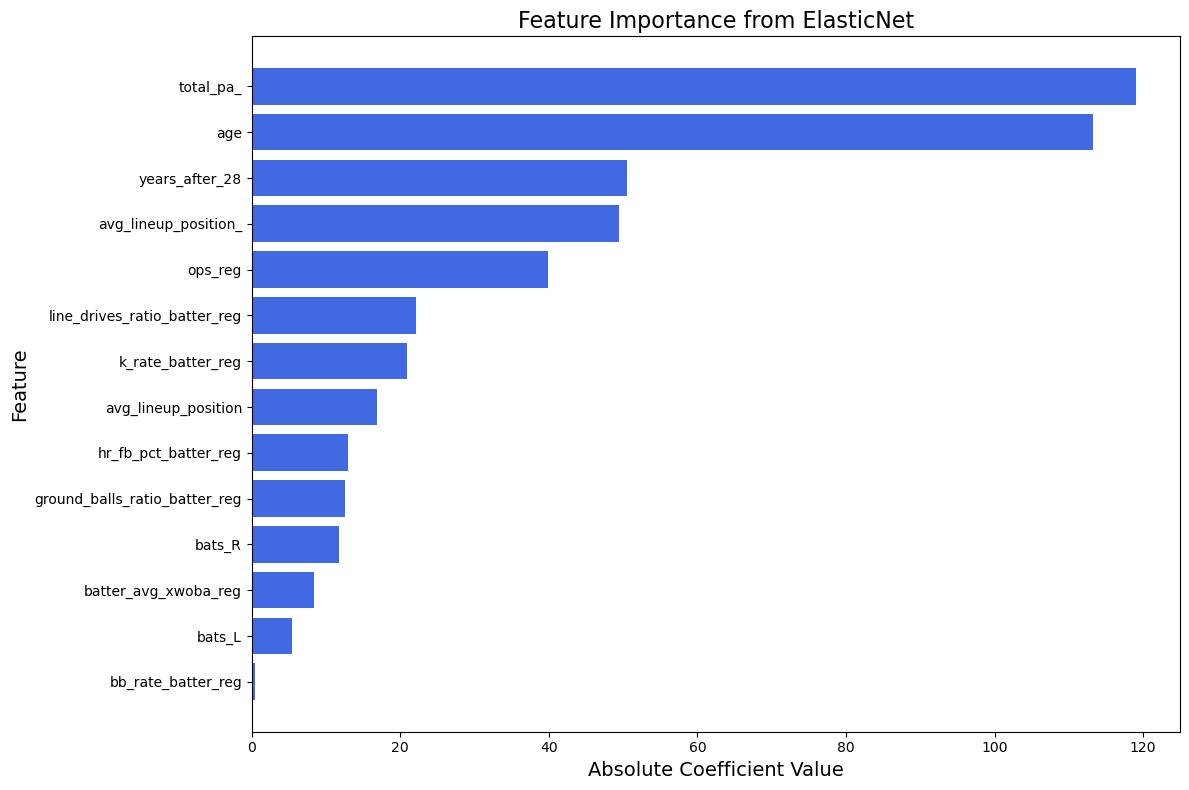

In [670]:
coefficients = elastic_net.coef_

# Create a DataFrame for the coefficients to associate with feature names
# After scaling, the feature names are lost, so we use the columns from X
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,  # Use the original feature names from X
    'Coefficient': coefficients
})

# Sort the features by the absolute value of the coefficients
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Print the feature importance
print(feature_importance)

# Set up the figure size
plt.figure(figsize=(12, 8))

# Create the bar plot
plt.barh(feature_importance['Feature'], feature_importance['Abs_Coefficient'], color='royalblue')

# Set labels and title
plt.xlabel('Absolute Coefficient Value', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.title('Feature Importance from ElasticNet', fontsize=16)

# Invert y-axis to show most important features at the top
plt.gca().invert_yaxis()

# Adjust layout to prevent cutoff
plt.tight_layout()

# Save and show the plot
plt.savefig("batting_feature_importance.jpg", bbox_inches='tight')
plt.show()

In [671]:
print("\nActual vs Predicted Values:")
print(pd.DataFrame({"Actual": y_test, "Predicted": y_pred}).head(20))  # Show first 20 rows


Actual vs Predicted Values:
     Actual   Predicted
208   638.0  624.415454
259   440.0  148.532095
97    233.0  181.058498
148     0.0    8.470340
395   425.0  275.728382
485     0.0  413.723112
234     9.0  116.747093
181     0.0   63.488102
604   431.0  201.347697
367     0.0  183.557346
260   617.0  488.369856
368     0.0  137.704612
451     0.0   30.315985
396   329.0  106.439435
351   111.0  205.437141
77    421.0  343.818283
607     0.0    0.000000
420   455.0  252.065315
174   504.0  332.352380
741     6.0  137.805791


In [672]:
df_batting.loc[741]

total_pa                              6.0
age                                  23.0
years_after_28                        0.0
bats                                    L
avg_lineup_position_                7.875
total_pa_                          15.625
avg_lineup_position              5.906514
ops_reg                          0.408911
k_rate_batter_reg                0.272622
bb_rate_batter_reg               0.018906
batter_avg_xwoba_reg              0.26057
ground_balls_ratio_batter_reg    0.168174
line_drives_ratio_batter_reg     0.191803
hr_fb_pct_batter_reg             0.039008
Name: 741, dtype: object

# Use model for predictions in 2024

In [674]:
df_batting_final = pd.read_csv('batter_features_final_model.csv')

In [675]:
df_batting_final.drop(columns=['Unnamed: 0','primary_position','total_pa','babip_batter_reg','popups_ratio_batter_reg','batter_avg_woba_reg','fly_balls_ratio_batter_reg','batter_avg_exp_ba_reg','year'], inplace=True)
X_new = df_batting_final.drop(columns='player_mlb_id')
player_ids = df_batting_final['player_mlb_id']

In [676]:
#convert categorical data
X_new = pd.get_dummies(X_new, drop_first=True)

In [677]:
# Scale features
numeric_cols = X_new.select_dtypes(include=np.number).columns

scaler = StandardScaler()
X_new[numeric_cols] = scaler.fit_transform(X_new[numeric_cols])

In [678]:
# Assuming X_new is preprocessed and has the same features as X_train
y_new_pred = elastic_net.predict(X_new)

# Ensure non-negative predictions (if applicable)
y_new_pred = np.maximum(y_new_pred, 0)


In [679]:
df_batting_predictions = pd.DataFrame({
    'player_id': player_ids,  # Make sure player_ids matches the length of y_new_pred
    'predicted_value': y_new_pred
})

In [680]:
df_batting_predictions.to_csv('batting_predictions.csv')